# Pubmed sequential sentence classification

* Research Paper - https://arxiv.org/abs/1710.06071

## Goal - (255 - 256)

* Download a text dataset (PubMed 200K RCT)
* Write a preprocessing function for our test data
* One Hot Encoding & Label Encoding.
* Setting up multiple modelling experiments with different levels of embedding
* Building a **multimodal model** to take in different sources of data
  * Replicating the model discussed in this paper (https://arxiv.org/abs/1710.06071)
  * Actual model description (https://arxiv.org/abs/1612.05251)
* Finding the most wrong predictions
* Reference Model

![Reference Model](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/model.jpg)

## SkimLit Inputs and Outputs (257) - Ignore

## Get the data (258 - 259)

Download the dataset for pubmed 200K RCT from https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [2]:
!dir pubmed-rct

 Volume in drive C is OS
 Volume Serial Number is 30F4-96C0

 Directory of C:\2023\data-science\20-Tensorflow\07-Skimlit\pubmed-rct

04-05-2023  13:08    <DIR>          .
27-05-2023  13:51    <DIR>          ..
04-05-2023  13:08    <DIR>          PubMed_200k_RCT
04-05-2023  13:08    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
04-05-2023  13:08    <DIR>          PubMed_20k_RCT
04-05-2023  13:08    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
04-05-2023  13:08             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  338,265,780,224 bytes free


In [3]:
import os

# root data directory
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
# list of file names
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


### Preprocess Data (260)

Write a function which will read each line of the file and create the below structure:

```
[{ 'line_number' : 0,
   'target'  : 'first few characters till \t tab character',
   'text'   : 'full text after \t character till end of line character \n',
   'total_lines' : 
 },
 ...
]
```

Ignore line starting with ### and repeat the same for train_data, validation_data and test_data

In [4]:
import os

def get_lines(file_name):
    """
    Reads the file_name and returns the content of the file as list
    """
    with open(file_name) as f:
        lines = f.readlines()
    return lines

validation_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])
train_lines = get_lines(filenames[2])

print(f"size of train lines is {len(train_lines)}")
print(f"size of validation lines is {len(validation_lines)}")
print(f"size of test lines is {len(test_lines)}")

def create_data_set(lines):
    data = []
    items = []
    index = 0
    for line in lines:
        
        if line.startswith('\n'):
            for item in items:
                item['total_lines'] = index -1
                data.append(item)
            index = 0
            items = []
        else:
            tokens = line.split('\t')
        
            if len(tokens) > 1:
                item = {'line_number':index,'target': tokens[0],'text':tokens[1].strip() ,'total_lines' :index}
                items.append(item)
                index = index + 1
    return data

train_data = create_data_set(train_lines)
validation_data = create_data_set(validation_lines)
test_data = create_data_set(test_lines)

print(f"size of train data is {len(train_data)}")
print(f"size of validation data is {len(validation_data)}")
print(f"size of test data is {len(test_data)}")


size of train lines is 210040
size of validation lines is 35212
size of test lines is 35135
size of train data is 180040
size of validation data is 30212
size of test data is 30135


### Visualize Data (261)

Use pandas dataframe

head of train data
   line_number     target                                               text  \
0            0  OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
1            1    METHODS  A total of @ patients with primary knee OA wer...   
2            2    METHODS  Outcome measures included pain reduction and i...   
3            3    METHODS  Pain was assessed using the visual analog pain...   
4            4    METHODS  Secondary outcome measures included the Wester...   

   total_lines  
0           11  
1           11  
2           11  
3           11  
4           11  
unique counts of each target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


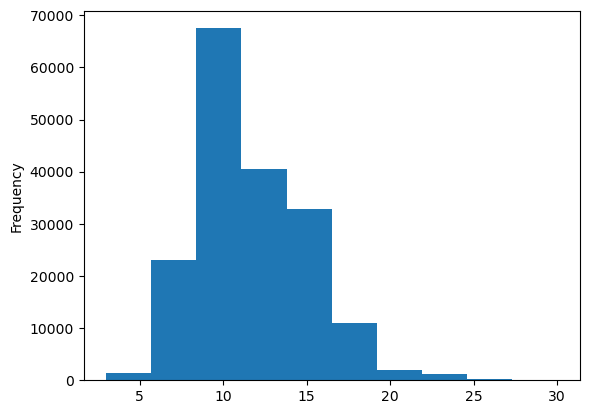

In [5]:
# Visualize data with data frame.

import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(train_data)
val_df   = pd.DataFrame(validation_data)
test_df  = pd.DataFrame(test_data)
# print the head
print('head of train data')
print(train_df.head())
print('unique counts of each target')
print(train_df['target'].value_counts())
# length of different lines
train_df.total_lines.plot.hist();


In [6]:
# convert to list
train_sentences = train_df['text'].tolist()
val_sentences   = val_df['text'].tolist()
test_sentences  = test_df['text'].tolist()
print(f"train sentences length {len(train_sentences)}")
print(f"val sentences length {len(val_sentences)}")
print(f"test sentences length {len(test_sentences)}")

train sentences length 180040
val sentences length 30212
test sentences length 30135


## One Hot Encoding & Label Encoding (262)

In [7]:
import sklearn
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf

#tf.debugging.set_log_device_placement(True)

onehot = OneHotEncoder(sparse_output=False)
train_label_one_hot = tf.constant(onehot.fit_transform(train_df['target'].to_numpy().reshape(-1,1)))
val_label_one_hot    = tf.constant(onehot.transform(val_df['target'].to_numpy().reshape(-1,1)))
test_label_one_hot   = tf.constant(onehot.transform(test_df['target'].to_numpy().reshape(-1,1)))
print('one hot encoding')
print(train_label_one_hot[0],val_label_one_hot[0],test_label_one_hot[0])

# label encoder
labelencode = LabelEncoder()
train_label_encoded = labelencode.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_encoded = labelencode.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_encoded = labelencode.transform(test_df['target'].to_numpy().reshape(-1,1))
print('label encoding...')
print(train_label_encoded[0],val_label_encoded[0],test_label_encoded[0])

print('classnames')
classnames = labelencode.classes_
print('class name = ', classnames, 'length of classes =', len(classnames))

one hot encoding
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64)
label encoding...
3 0 0
classnames
class name =  ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] length of classes = 5


C:\Users\Rupak\.conda\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Rupak\.conda\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Experiments to be Conducted (262)

![Experiments](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/experiments.jpg)

## Model 0 - Naive Bayes with TF-IDF Encoder (263)

* Selection Method
![Machine Learning Map](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/ml_map.png)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

def find_scores(val_label_encoded,val_preds):
    a_score = accuracy_score(y_true=val_label_encoded,y_pred=val_preds)
    p_score = precision_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
    r_score = recall_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
    f_score = f1_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
    return {'accuracy_score' : a_score, 
            'precision_score' : p_score, 
            'recall_score' : r_score,
            'f1_score' : f_score}

model_0 = Pipeline([('tf-idf',TfidfVectorizer()),
               ('naive_bayes',MultinomialNB())])
model_0.fit(X=train_sentences,y=train_label_encoded)

y_pred = model_0.score(X=val_sentences,y=val_label_encoded)

val_preds = model_0.predict(val_sentences)
model_0_results = find_scores(val_label_encoded,val_preds)
print(model_0_results)

{'accuracy_score': 0.7218323844829869, 'precision_score': 0.7186466952323352, 'recall_score': 0.7218323844829869, 'f1_score': 0.6989250353450294}


## Model 1 - Conv1D with token Embedding 

### Data Visualization (264)

mean tokens in each sentences  26.338269273494777
no of tokens to keep to cover 95% of the sentence tokens in training data is 55


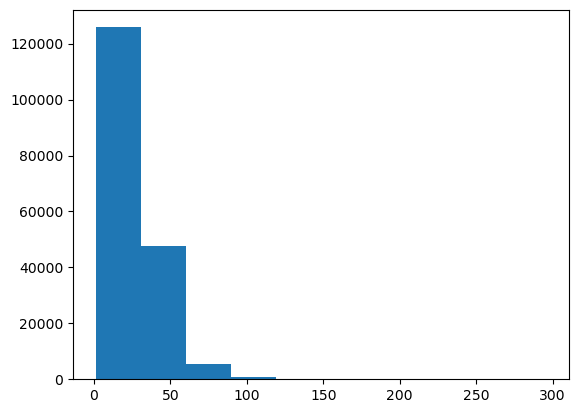

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# find how tokens is each sentences
lengths = [len(sen.split()) for sen in train_sentences]
print('mean tokens in each sentences ', np.mean(lengths))
output_sequence_length = int(np.percentile(lengths,95))
# find percentile to cover 95% of the sentence tokens
print(f"no of tokens to keep to cover 95% of the sentence tokens in training data is {output_sequence_length}")
plt.hist(lengths,bins=10);

### Vectorize Tokens (265)

In [10]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_sequence_length=output_sequence_length)

text_vectorization.adapt(train_sentences)

# check the output of text vectorization
import random
sample_sentence = random.choice(train_sentences)
print(f"Sample Sentence Text \n {sample_sentence}\n")
print(f"length of the Sample Sentence {len(sample_sentence)}")
print(f"Vectorized Sample Sentence\n {text_vectorization([sample_sentence])}")

# how many words in our vocabulary
rct_20k_text_vocab = text_vectorization.get_vocabulary()
print(f"total no of words in the vocabulary is {len(rct_20k_text_vocab)}")
print(f"most common words in the vocabulary is \n {rct_20k_text_vocab[:10]}")
print(f"least common words in the vocabulary is \n {rct_20k_text_vocab[-10:]}")

# print text vectorization config
t_config = text_vectorization.get_config()
print(t_config)

Sample Sentence Text 
 Advance care planning ( ACP ) provides patients with the ability to make their decisions known about how they would like to be treated if they lose capacity .

length of the Sample Sentence 158
Vectorized Sample Sentence
 [[5155   77 2076 9492  828   12    7    2  805    6 2329  120 2431  682
   338  898  316  495 2860    6   36  172  324  316 7497  713    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
total no of words in the vocabulary is 64841
most common words in the vocabulary is 
 ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
least common words in the vocabulary is 
 ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
{'name': 'text_vectorization', 'trainable': True, 'batch_input_shape': (None,), 'dtype': 'string', 'max_tokens': 68000, 'standardize': 'lower_and_strip_punctuation', 'split': '

### Token Embedding (266)

In [11]:
# add a embedding layer
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(input_dim=len(rct_20k_text_vocab),
                 output_dim=128,
                  mask_zero=True,
                  name='token_embedding')
# token embedding
print(f"Sentence before embedding \n {sample_sentence}")
vectorized_sentence = text_vectorization([sample_sentence])
print(f"vectorized sentence \n {vectorized_sentence}")
embed_sentence = embedding_layer(vectorized_sentence)
print(f"embedded sentence \n {embed_sentence}")
print(f"embedded sentence shape \n {embed_sentence.shape}")

Sentence before embedding 
 Advance care planning ( ACP ) provides patients with the ability to make their decisions known about how they would like to be treated if they lose capacity .
vectorized sentence 
 [[5155   77 2076 9492  828   12    7    2  805    6 2329  120 2431  682
   338  898  316  495 2860    6   36  172  324  316 7497  713    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
embedded sentence 
 [[[-0.01283991  0.02463413 -0.04823352 ...  0.00433755 -0.03169407
   -0.04195577]
  [ 0.03574825  0.0480192   0.03930352 ...  0.02426518 -0.02064445
    0.02254102]
  [ 0.01092899 -0.03590836 -0.0426386  ...  0.01795794  0.03125622
   -0.0225942 ]
  ...
  [-0.01032238 -0.03818301 -0.04569026 ... -0.02215034  0.04288134
   -0.04169292]
  [-0.01032238 -0.03818301 -0.04569026 ... -0.02215034  0.04288134
   -0.04169292]
  [-0.01032238 -0.03818301 -0.04569026 ... -0.02215034  0.0428813

## Create Dataset using tf.data.Dataset (267)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_label_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_label_one_hot))

# for fast performance 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Build Conv1D model (268)

In [14]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Input, TextVectorization, Embedding,Dense

# input layer
inputs = Input(shape=(1,),dtype=tf.string,name="input")
# text vectorization layer
max_tokens = 68000
lengths = [len(sen.split()) for sen in train_sentences]
output_sequence_length = int(np.percentile(lengths,95))
text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                      output_sequence_length=output_sequence_length,
                                   name="vectorization_layer")
text_vectorizer.adapt(train_sentences)
vectors = text_vectorizer(inputs)
# embedding layer
embedding = Embedding(input_dim=len(rct_20k_text_vocab),
                     output_dim=128,
                     mask_zero=True,
                      name="token_embedding_layer")
token_embedding = embedding(vectors)
# conv1d layer
x = Conv1D(filters=64,
          kernel_size=5,
          padding="same",
          activation="relu",
          name="conv1d_Layer")(token_embedding)
# average pooling
x = GlobalAveragePooling1D(name="global_average_pooling")(x)
# output layer
outputs = Dense(5,activation="softmax", name="fully_connected")(x)
# finally the model
model_1 = Model(inputs,outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
# summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 vectorization_layer (TextVe  (None, 55)               0         
 ctorization)                                                    
                                                                 
 token_embedding_layer (Embe  (None, 55, 128)          8299648   
 dding)                                                          
                                                                 
 conv1d_Layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling (Glo  (None, 64)               0         
 balAveragePooling1D)                                            
                                                             

In [15]:
import time

def fit_the_model(model):
    
    # fit the model
    start_time = time.time()
    history = model.fit(train_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1*len(val_dataset)))
    time_taken = time.time() - start_time
    print(f"time taken to fit {time_taken}")
    return history

In [16]:
# let's try with cpu
#with tf.device("/cpu:0"):
#    fit_the_model(model_1)

In [17]:
# with gpu
with tf.device("/gpu:0"):
    fit_the_model(model_1)

Epoch 1/3
562/562 [==============================] - 32s 55ms/step - loss: 0.9165 - accuracy: 0.6371 - val_loss: 0.6877 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 31s 55ms/step - loss: 0.6616 - accuracy: 0.7542 - val_loss: 0.6369 - val_accuracy: 0.7636
Epoch 3/3
562/562 [==============================] - 31s 54ms/step - loss: 0.6201 - accuracy: 0.7725 - val_loss: 0.6008 - val_accuracy: 0.7856
time taken to fit 93.83097410202026


In [18]:
# evalue the model
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6033 - accuracy: 0.7859


[0.6033049821853638, 0.7858797907829285]

In [19]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.4859353e-01, 1.6534175e-01, 6.9871642e-02, 2.9042551e-01,
         2.5767684e-02],
        [4.4612807e-01, 2.7217397e-01, 1.0024450e-02, 2.6532724e-01,
         6.3463114e-03],
        [1.5241912e-01, 1.1685584e-02, 2.0001212e-03, 8.3386564e-01,
         2.9620685e-05],
        ...,
        [5.8844103e-06, 8.3490810e-04, 7.0643640e-04, 2.9870721e-06,
         9.9844980e-01],
        [6.4550601e-02, 4.6901977e-01, 1.0379394e-01, 7.8702159e-02,
         2.8393355e-01],
        [1.4012037e-01, 6.9039452e-01, 3.7826963e-02, 5.3091891e-02,
         7.8566231e-02]], dtype=float32),
 (30212, 5))

In [20]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [21]:
model_1_results = find_scores(val_label_encoded,model_1_preds)
model_0_results,model_1_results,

({'accuracy_score': 0.7218323844829869,
  'precision_score': 0.7186466952323352,
  'recall_score': 0.7218323844829869,
  'f1_score': 0.6989250353450294},
 {'accuracy_score': 0.7858797828677346,
  'precision_score': 0.7832855515301821,
  'recall_score': 0.7858797828677346,
  'f1_score': 0.7835312857204537})

## Model 2 Architecture - Tensorflow Hub Pretrained Feature Extractor (269 - 270)
![Model 2 Architecture](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/model_2_architecture.jpg)

In [22]:
import tensorflow_hub as hub
import random
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

with tf.device('/cpu:0'):
    use = 'https://tfhub.dev/google/universal-sentence-encoder/4'
    universal_sentence_encoder = hub.KerasLayer(use,
                              trainable=False,
                              name='universal_encoder_layer')

In [23]:
random_sentence = random.choice(train_sentences)
print(f"random sentence to encode with hub encoder \n {random_sentence}")
random_sentence_encoded = universal_sentence_encoder([random_sentence])
print(f"shape of encoded sentence {random_sentence_encoded.shape}")
print(f"encoded sentence \n {random_sentence_encoded}")

random sentence to encode with hub encoder 
 To assess clinicians ' proficiency in delivering manually applied traction forces within specified ranges to neck pain patients .
shape of encoded sentence (1, 512)
encoded sentence 
 [[ 0.00818086  0.01406605  0.00090491 -0.02453211  0.00499058 -0.01102805
  -0.00554117  0.00472231 -0.05486783  0.04848744  0.07914858 -0.00417906
   0.04354773  0.0375264   0.05290315 -0.03064974 -0.07309259  0.00519272
  -0.01293105 -0.07170687 -0.05588749  0.06809901 -0.07535539 -0.04038442
   0.03581334  0.03172006 -0.07502083 -0.00187953  0.00562391 -0.00316229
  -0.00347002  0.08198426  0.02324394 -0.01267684 -0.00022445  0.0810481
   0.00531406  0.06518734 -0.05126475 -0.07501567 -0.05527934  0.03293367
  -0.00351871 -0.04098328  0.03975638  0.06621411  0.06214466  0.0199849
   0.02215517  0.00192791 -0.07289242  0.0214725   0.04670047  0.05553294
   0.01250336 -0.06722727 -0.02779219  0.03526707  0.04716508 -0.01797582
   0.03856713  0.07209621 -0.0641

In [24]:
# create model 2
inputs = Input(shape=[],dtype=tf.string,name='input_layer')
pretrained_embedding = universal_sentence_encoder(inputs)
dense = Dense(128,activation='relu',name='fully_connected_layer')(pretrained_embedding)
outputs = Dense(5,activation='softmax',name='output_layer')(dense)
model_2 = Model(inputs=inputs,
               outputs=outputs,
               name='model_2_use_feature_extractor')
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_encoder_layer (Ke  (None, 512)              256797824 
 rasLayer)                                                       
                                                                 
 fully_connected_layer (Dens  (None, 128)              65664     
 e)                                                              
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [25]:
model_2_history = fit_the_model(model_2)

Epoch 1/3
562/562 [==============================] - 10s 12ms/step - loss: 0.9165 - accuracy: 0.6484 - val_loss: 0.7963 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7691 - accuracy: 0.7020 - val_loss: 0.7548 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7537 - accuracy: 0.7102 - val_loss: 0.7407 - val_accuracy: 0.7118
time taken to fit 23.069999933242798


In [26]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7426 - accuracy: 0.7130


[0.7425603270530701, 0.712961733341217]

In [27]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.4705698e-01, 3.5128254e-01, 2.2234267e-03, 1.9201747e-01,
        7.4195480e-03],
       [3.9106750e-01, 4.6689376e-01, 3.7509776e-03, 1.3610907e-01,
        2.1786643e-03],
       [2.2799286e-01, 1.3777003e-01, 1.7880812e-02, 5.8207357e-01,
        3.4282718e-02],
       ...,
       [1.8965325e-03, 4.8858067e-03, 5.4489128e-02, 9.1219839e-04,
        9.3781638e-01],
       [4.5123021e-03, 4.7256242e-02, 2.1779539e-01, 1.7584325e-03,
        7.2867769e-01],
       [1.7100213e-01, 2.7553585e-01, 4.9864376e-01, 6.9761956e-03,
        4.7842197e-02]], dtype=float32)

In [28]:
model_2_pred = tf.argmax(model_2_pred_probs,axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [29]:
model_2_results = find_scores(val_label_encoded,model_2_pred)

In [30]:
model_2_results,model_1_results,model_0_results

({'accuracy_score': 0.7129617370581226,
  'precision_score': 0.7129614303693675,
  'recall_score': 0.7129617370581226,
  'f1_score': 0.7100447775199908},
 {'accuracy_score': 0.7858797828677346,
  'precision_score': 0.7832855515301821,
  'recall_score': 0.7858797828677346,
  'f1_score': 0.7835312857204537},
 {'accuracy_score': 0.7218323844829869,
  'precision_score': 0.7186466952323352,
  'recall_score': 0.7218323844829869,
  'f1_score': 0.6989250353450294})

## Model-3 : Conv1D with character embedding

![Model 3 Architecture](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/model_3_architecture.jpg)

### Character Embedding Layer

In [31]:
import random
from tensorflow.data import Dataset
# prepare data
def split_chars(sentence):
    return ' '.join(list(sentence))


training_char_sentences = [split_chars(sentence.lower()) for sentence in train_sentences]
val_char_sentences      = [split_chars(sentence.lower()) for sentence in val_sentences]
test_char_sentences     = [split_chars(sentence.lower()) for sentence in test_sentences]
training_char_sentences[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [32]:
len(train_sentences[0]), len(training_char_sentences[0])

(281, 561)

In [33]:
!nvidia-smi

Sat May 27 16:34:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P3               17W /  N/A|      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.data import Dataset
import string
import numpy as np

lengths_of_sentences = [len(sentence) for sentence in training_char_sentences]
# find no of tokens to take to cover 95 % of the data
max_length = int(np.percentile(lengths_of_sentences,95)) # sequence length to pad the outputs to
print(f"number of tokens to consider {max_length} ")
# find vocab length
all_printable = string.ascii_lowercase + string.digits + string.punctuation
max_features = len(all_printable); # no of characters in the vocabulary
char_vectorizer = TextVectorization(max_tokens=max_features,
                                   output_sequence_length=max_length,
                                   name='character_vectorization')

#test_char_dataset  = Dataset.from_tensor_slices((test_char_sentences,test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

char_vectorizer.adapt(training_char_sentences)
vocab = char_vectorizer.get_vocabulary()
sample_char_sentence = random.choice(training_char_sentences)
print(f"vocabulary \n {vocab}")
print(f"vocabulary length \n {len(vocab)}")
sample_sentence_encoded = char_vectorizer([sample_char_sentence])
print(f"encoded random sample \n {sample_sentence_encoded}")
print(f"shape of encoded sample char sentence \n {sample_sentence_encoded.shape}")

number of tokens to consider 579 
vocabulary 
 ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']
vocabulary length 
 28
encoded random sample 
 [[10  7 18  9 20  2  8  2  5 12 12  7 11  5  3  2 10  8  5  6 10  7 15 12
  19  4  6  3  7  3 13  8  2  2 18  8  7 16 14  9  8  2 11  2  4 21  4  6
  18  5  9 14  8  2  5  6  5  2  9  3 13  2  3  4 11 15  2 10  4 11  5  3
   4  7  6  6  7 10  2 24 15  2 10  2  3  7 15  4 10  4  6  2 10 18 23 18
  10  2 24 15  2 10  2  3  7 15  4 10  4  6  2 10  4  6  3  8  5 15 16  9
  11 16 12  5  8 12 19  4 15  7  8 18 23 18 10  2 24 15  2 10  2  3  7 15
   4 10  4  6  2  4 15 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

In [35]:
# embedding layer
from tensorflow.keras.layers import Embedding

char_embedding = Embedding(input_dim=len(vocab),
                          output_dim=25,
                          mask_zero=True,
                          name='char_embedding_layer')
char_embedding_sample = char_embedding(sample_sentence_encoded)
char_embedding_sample

<tf.Tensor: shape=(1, 579, 25), dtype=float32, numpy=
array([[[ 0.03534449, -0.01286523, -0.00624593, ...,  0.02392114,
         -0.02095555, -0.00049011],
        [-0.003483  ,  0.03116118,  0.04259148, ...,  0.04505383,
          0.00096996, -0.0045164 ],
        [ 0.01499068,  0.03566793, -0.00343667, ...,  0.00104467,
          0.00169986,  0.02560656],
        ...,
        [-0.0022387 ,  0.00044673,  0.04088444, ..., -0.00736386,
          0.00960143, -0.03004181],
        [-0.0022387 ,  0.00044673,  0.04088444, ..., -0.00736386,
          0.00960143, -0.03004181],
        [-0.0022387 ,  0.00044673,  0.04088444, ..., -0.00736386,
          0.00960143, -0.03004181]]], dtype=float32)>

### Create Full Model

In [36]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(1,),dtype=tf.string,name='input_layer')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = Conv1D(filters=64,
          kernel_size=5,
          padding='same',
          activation='relu',
          name='conv_1d_layer')(char_embeddings)
x = GlobalMaxPooling1D(name='GlobalAveragePooling1D')(x)
outputs = Dense(units=5,activation='softmax',name='full_connected')(x)
model_3 = Model(inputs,outputs)

In [37]:
# compile the model
model_3.compile(loss='categorical_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

### Model Summary

In [38]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 character_vectorization (Te  (None, 579)              0         
 xtVectorization)                                                
                                                                 
 char_embedding_layer (Embed  (None, 579, 25)          700       
 ding)                                                           
                                                                 
 conv_1d_layer (Conv1D)      (None, 579, 64)           8064      
                                                                 
 GlobalAveragePooling1D (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                           

### Fit the Model

In [39]:
train_char_dataset = Dataset.from_tensor_slices((training_char_sentences,train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset   = Dataset.from_tensor_slices((val_char_sentences,val_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [40]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps=int(0.1* len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 17ms/step - loss: 1.2693 - accuracy: 0.4845 - val_loss: 1.0508 - val_accuracy: 0.5775
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 1.0201 - accuracy: 0.5932 - val_loss: 0.9465 - val_accuracy: 0.6330
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.9427 - accuracy: 0.6305 - val_loss: 0.8714 - val_accuracy: 0.6672


### Evaluate the Model

In [41]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9061 - accuracy: 0.6484


[0.9060515761375427, 0.6483847498893738]

In [42]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[0.14712763, 0.3116202 , 0.20787427, 0.30352074, 0.0298571 ],
       [0.16681269, 0.54253685, 0.04115377, 0.1864673 , 0.06302937],
       [0.25745144, 0.16107936, 0.19938114, 0.34759235, 0.03449571],
       ...,
       [0.01519194, 0.03389669, 0.20543973, 0.02479323, 0.7206784 ],
       [0.05014108, 0.17210321, 0.38640454, 0.04260339, 0.34874776],
       [0.48146206, 0.35471576, 0.0987377 , 0.04336251, 0.02172194]],
      dtype=float32)

In [43]:
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0], dtype=int64)>

In [44]:
model_3_results = find_scores(val_label_encoded,model_3_preds)
model_3_results

{'accuracy_score': 0.6483847477823381,
 'precision_score': 0.6421119942498236,
 'recall_score': 0.6483847477823381,
 'f1_score': 0.638241600085007}